In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [12]:
train = pd.read_csv('../original_data/train_FD001.txt', sep=" ", header=None)
test = pd.read_csv('../original_data/test_FD001.txt', sep=" ", header=None)
test_labels = pd.read_csv('../original_data/RUL_FD001.txt', sep=" ", header=None)

In [13]:
unit_and_cycle = ["Unit_Number", "Cycle#"]
oper_setting = ["Operational_Setting_"+str(i) for i in range(1,4)]
sensors = ["Sensor_"+str(j) for j in range(1,22)] 
col_names = unit_and_cycle + oper_setting + sensors
print(col_names)

['Unit_Number', 'Cycle#', 'Operational_Setting_1', 'Operational_Setting_2', 'Operational_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [14]:
train.drop([26, 27], axis=1, inplace=True)
test.drop([26, 27], axis=1, inplace=True)
test_labels.drop([1], axis=1, inplace=True)

In [15]:
train.columns = col_names
test.columns = col_names

In [17]:
RUL_test = pd.read_csv('../cleaned_data/test.csv').iloc[:,-1]
RUL_train =  pd.read_csv('../cleaned_data/train.csv').iloc[:,-1]

In [18]:
train['RUL'] = RUL_train
test['RUL'] = RUL_test

In [20]:
matplotlib.rcParams['figure.dpi']= 100

In [16]:
unit_1 = train[train["Unit_Number"] == 1]

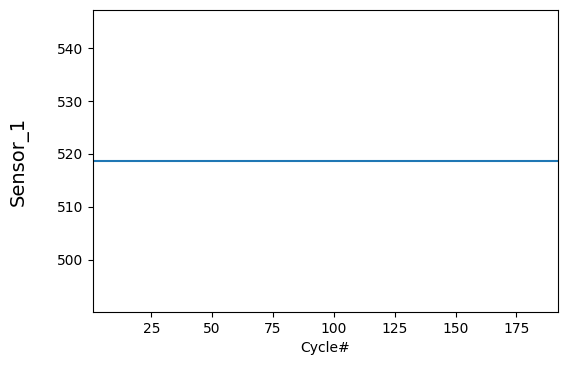

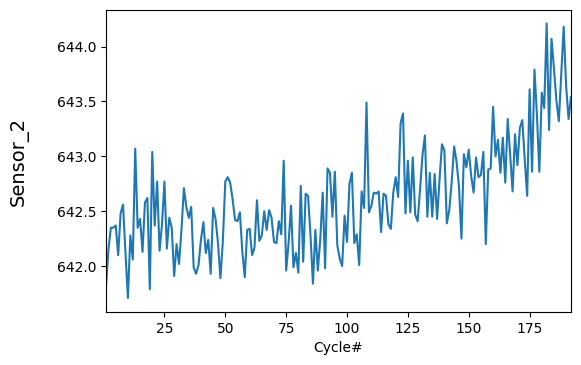

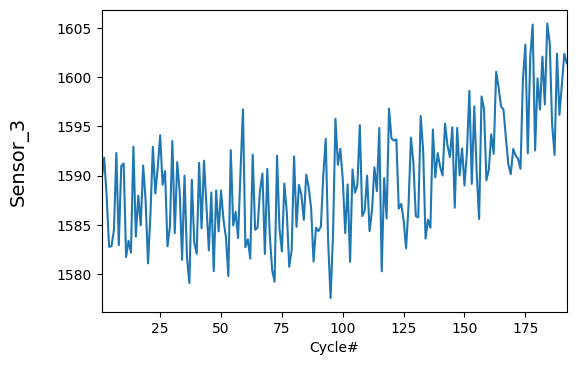

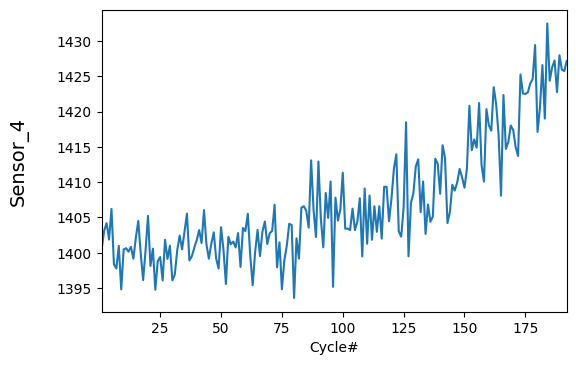

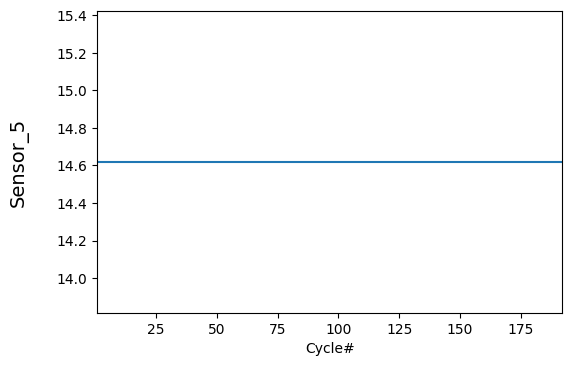

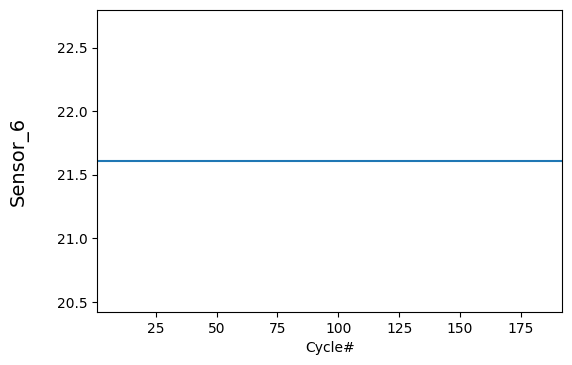

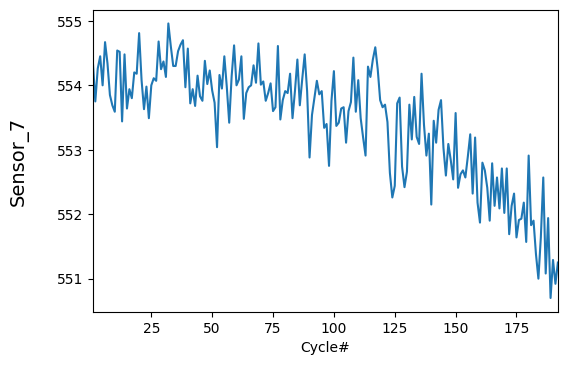

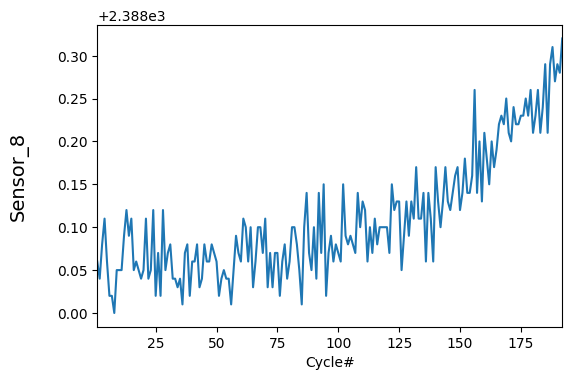

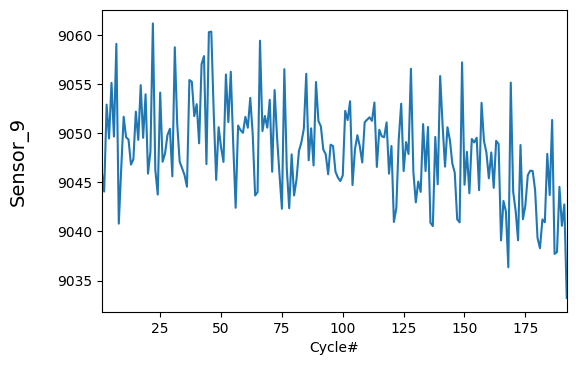

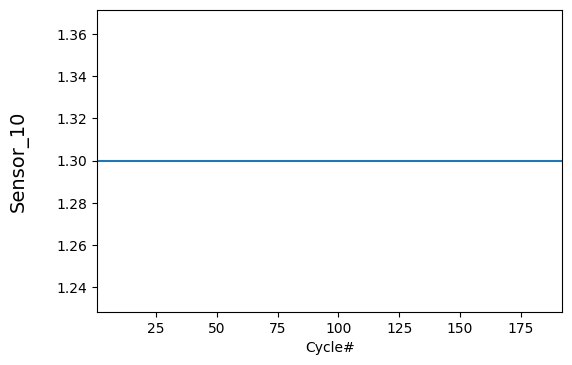

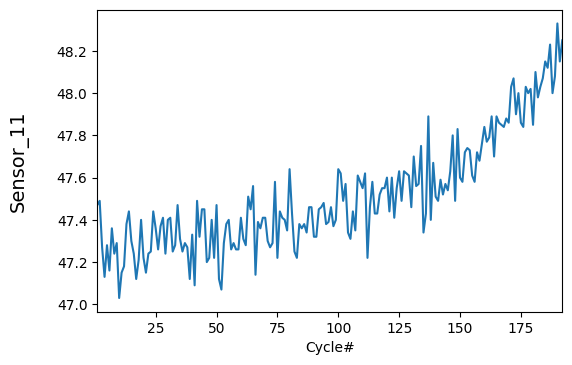

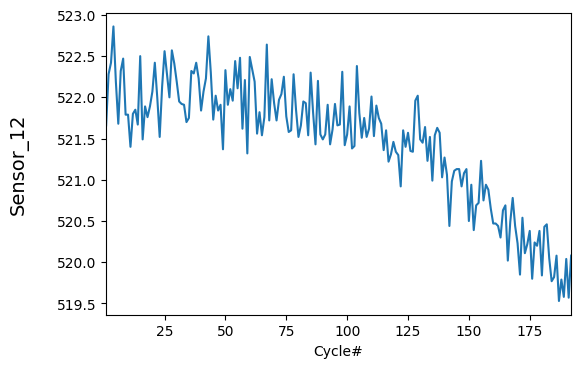

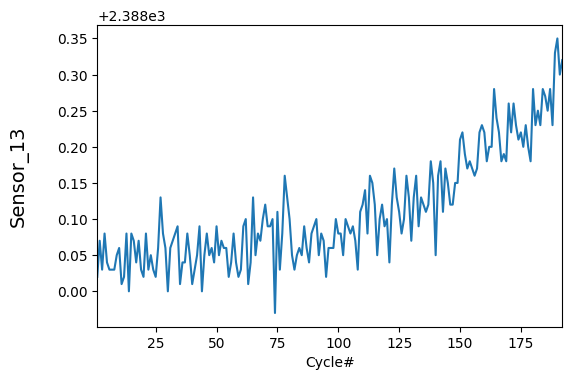

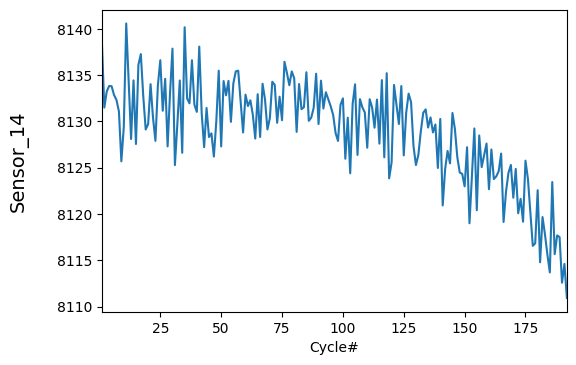

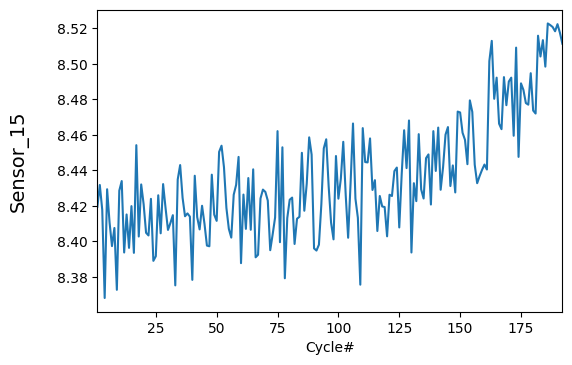

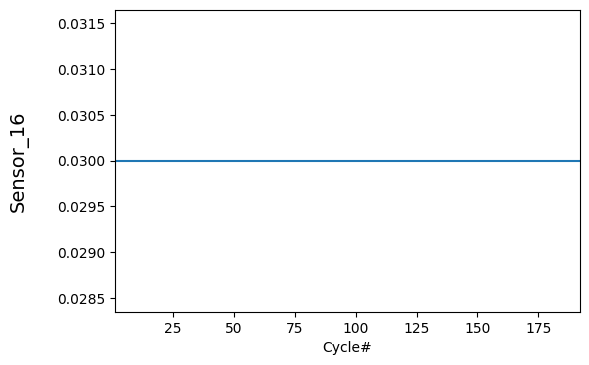

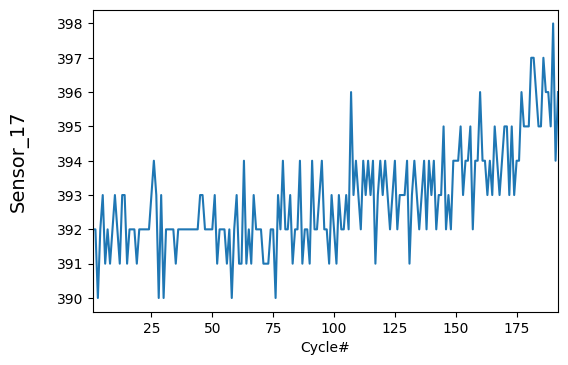

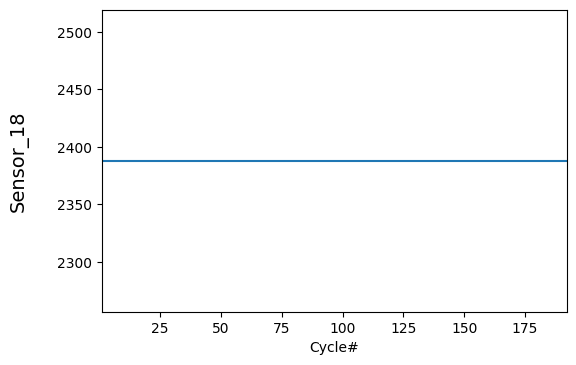

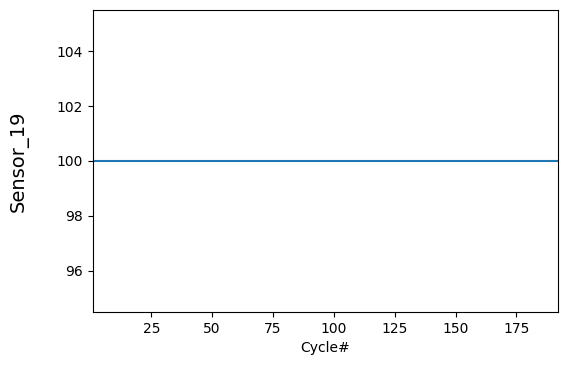

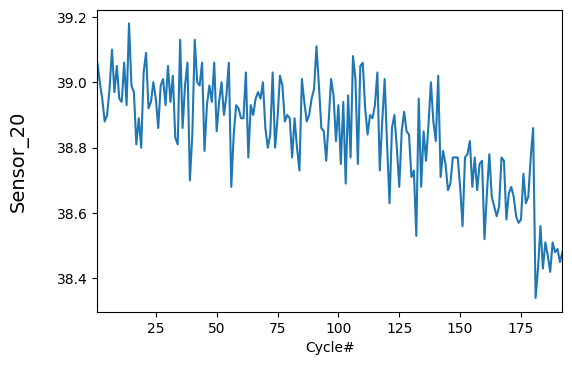

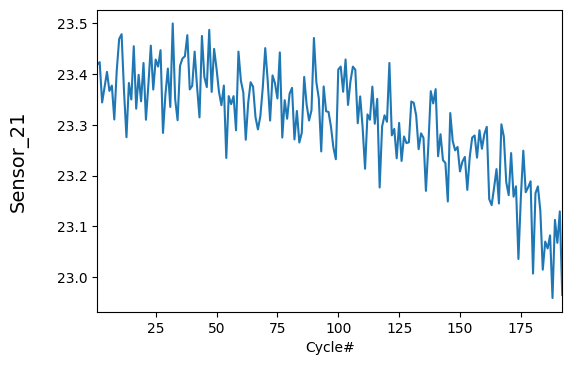

In [29]:
for i in range(1, 22):
    final_str = 'Sensor_' + str(i)
    unit_1.set_index('Cycle#')[final_str].plot();
    plt.ylabel(final_str, fontsize=14, labelpad=20)
    plt.show()

Sensors of Interest are:
2,3,4,7,8,9, 11, 12, 13, 14, 15, 17, 20, 21, 

In [21]:
train_new = train.loc[:,["Sensor_2","Sensor_3","Sensor_4","Sensor_7","Sensor_8","Sensor_9","Sensor_11","Sensor_12","Sensor_13","Sensor_14","Sensor_15","Sensor_17",
                  "Sensor_20","Sensor_21", "RUL"]]
test_new = test.loc[:,["Sensor_2","Sensor_3","Sensor_4","Sensor_7","Sensor_8","Sensor_9","Sensor_11","Sensor_12","Sensor_13","Sensor_14","Sensor_15","Sensor_17",
                  "Sensor_20","Sensor_21", "RUL"]]

In [11]:
train_data_to_be_scaled = train_new.iloc[:,:-1]
test_data_to_be_scaled = test_new.iloc[:,:-1]

In [12]:
scaler = StandardScaler().fit(train_data_to_be_scaled)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
train_scaled = pd.DataFrame(scaler.transform(train_data_to_be_scaled))
test_scaled = pd.DataFrame(scaler.transform(test_data_to_be_scaled))

In [14]:
new_col_names = ["Sensor_2","Sensor_3","Sensor_4","Sensor_7","Sensor_8","Sensor_9","Sensor_11","Sensor_12","Sensor_13","Sensor_14","Sensor_15","Sensor_17",
                  "Sensor_20","Sensor_21"]

In [15]:
train_scaled.columns = new_col_names
test_scaled.columns = new_col_names

In [16]:
train_scaled["RUL"] = train_new['RUL']
test_scaled["RUL"] = test_new['RUL']

In [17]:
X = train_scaled.iloc[:,:-1]
y = train_scaled.iloc[:, -1]

In [54]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

clf = RandomForestRegressor(n_estimators=500, random_state=99, n_jobs=-1, max_depth=20)
clf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=99, verbose=0, warm_start=False)

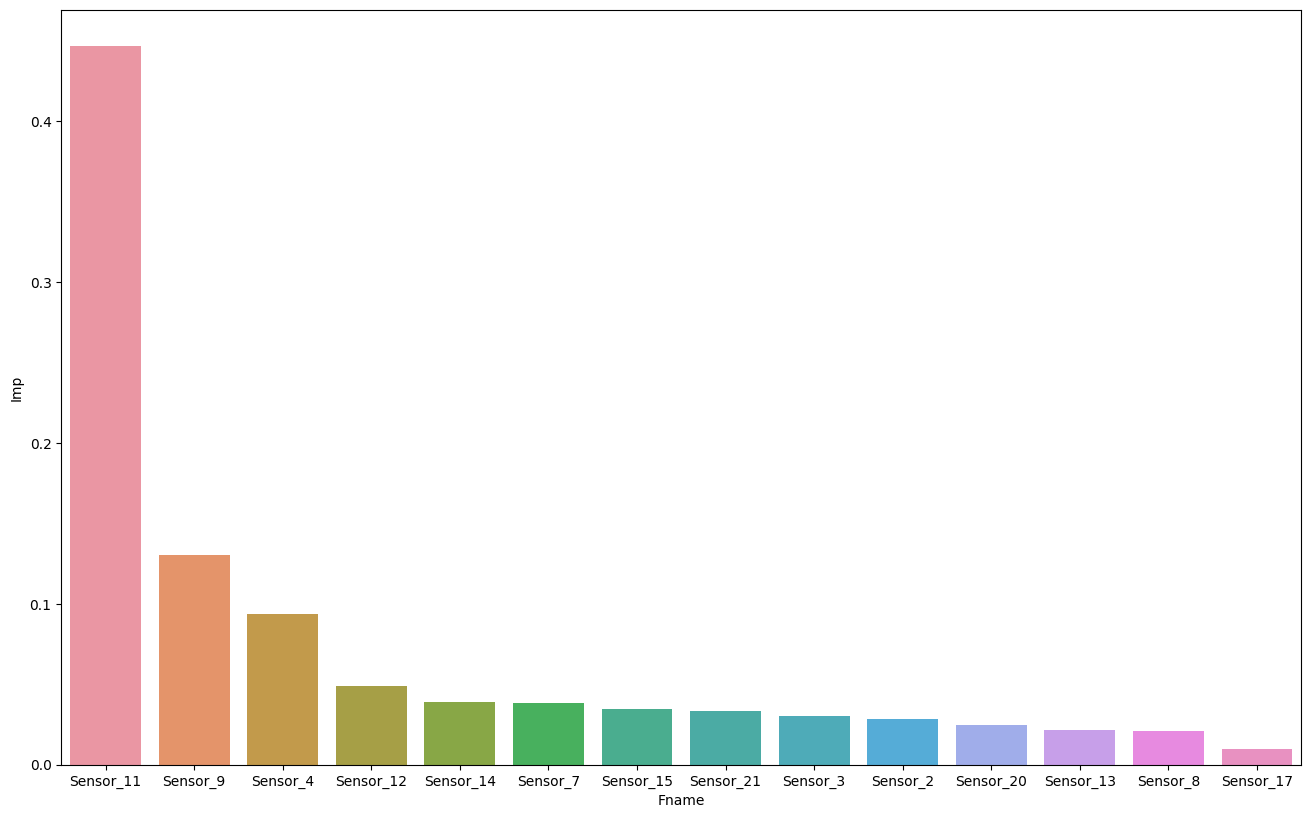

In [55]:
df_importances = pd.DataFrame()

df_importances["Fname"] = X.columns
df_importances["Imp"] = clf.feature_importances_
df_importances.sort_values(by=['Imp'], inplace=True, ascending=False)

plt.figure(figsize=(16,10))
ax = sns.barplot(x="Fname", y="Imp", data=df_importances)

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

features_dict = {}
num_features = []
features = []
mse_score_RT = []
r2_scores_RT = []

sorted_imp = np.sort(clf.feature_importances_)
reverse_sorted = sorted_imp[::-1]
for i in range(1, 17):
    features_tmp =[]
    for elem in (reverse_sorted[:i]):
        features_tmp.append(list(X.columns[np.where(clf.feature_importances_ == elem)]))
    flattened = [val for sublist in features_tmp for val in sublist]    
    tree_prime = DecisionTreeRegressor().fit(X.loc[:,flattened], y)
    features_dict[i]  = flattened
    features.append(i)
    mse_score_RT.append(mean_squared_error(y,tree_prime.predict(X.loc[:,flattened])))
    r2_scores_RT.append(r2_score(y, tree_prime.predict(X.loc[:,flattened])))

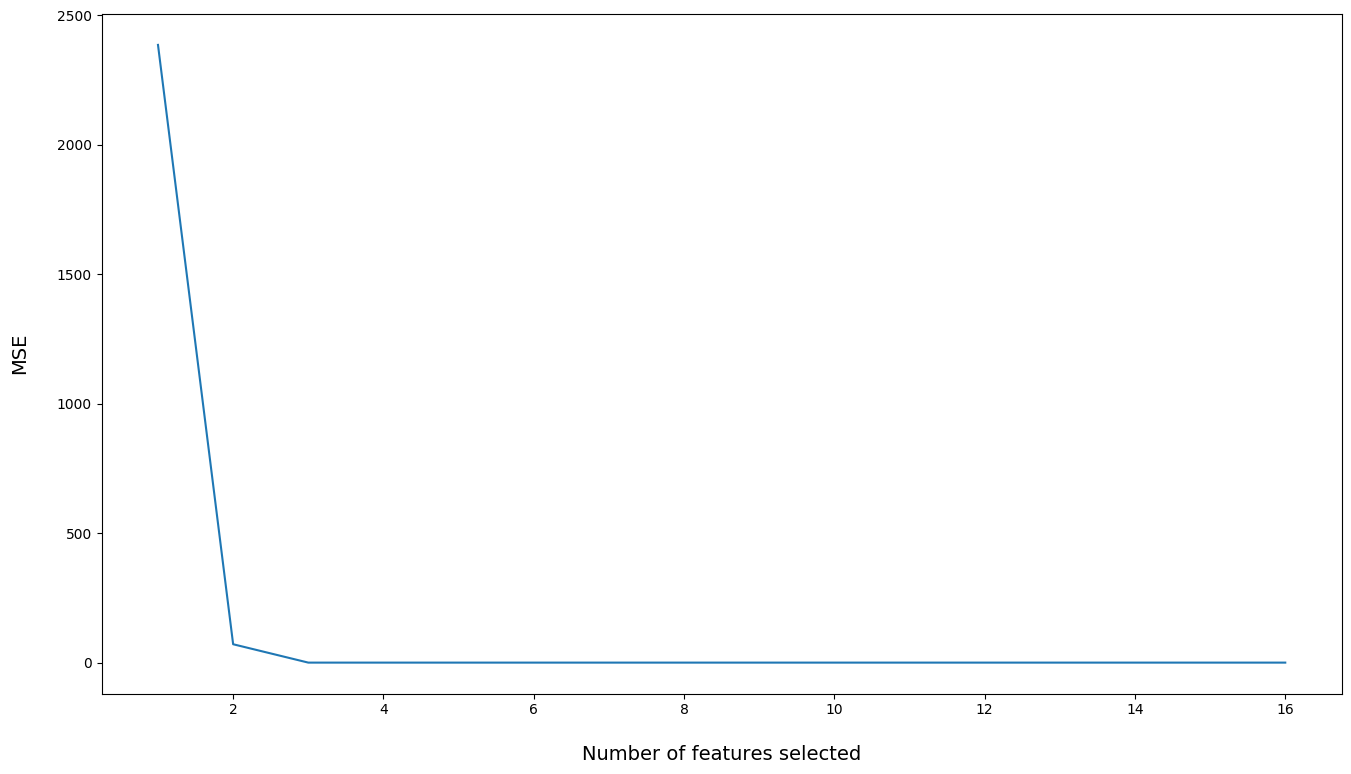

In [58]:
plt.figure(figsize=(16, 9))
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('MSE', fontsize=14, labelpad=20)
plt.plot(features, mse_score_RT)

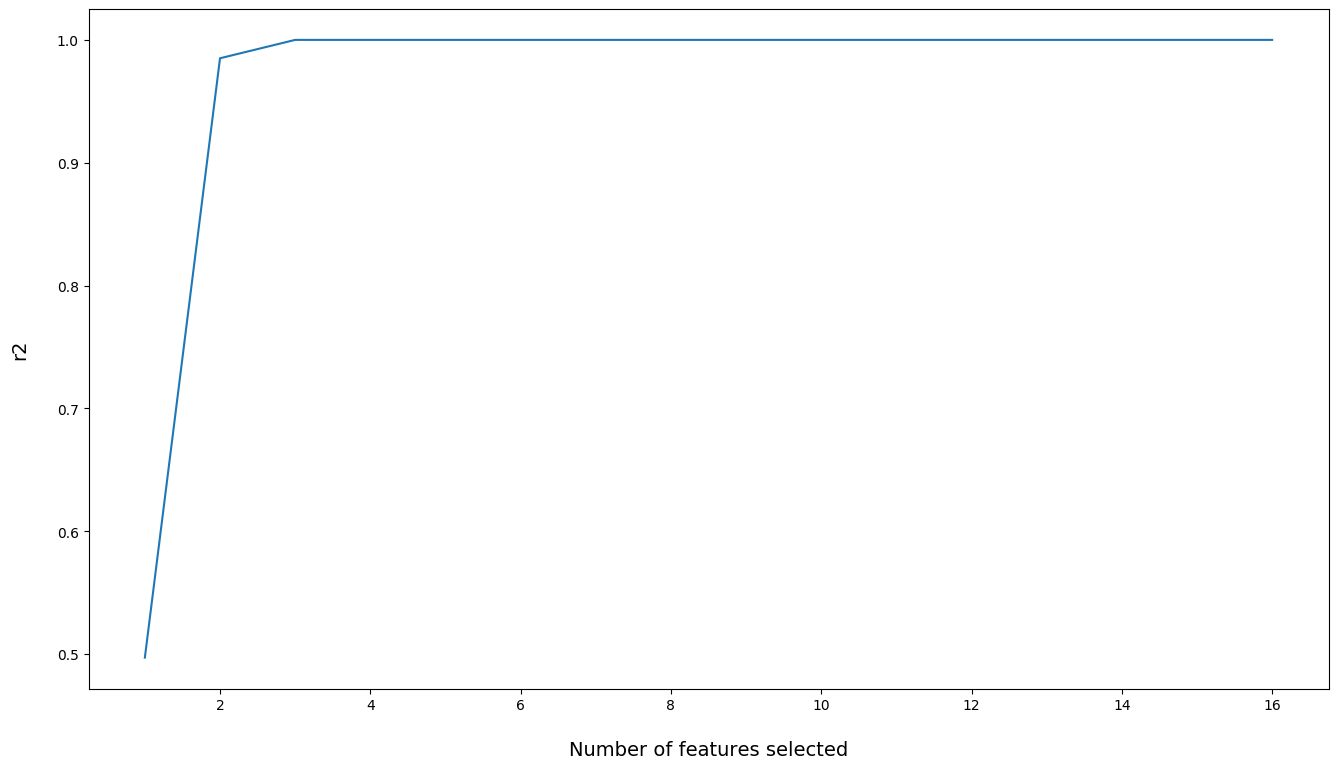

In [59]:
plt.figure(figsize=(16, 9))
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('r2', fontsize=14, labelpad=20)
plt.plot(features, r2_scores_RT)

In [60]:
print("Selected Features are \n {}".format(features_dict[5]))

Selected Features are 
 ['Sensor_11', 'Sensor_9', 'Sensor_4', 'Sensor_12', 'Sensor_14']


In [18]:
selected_features = X.loc[:,['Sensor_11', 'Sensor_9', 'Sensor_4', 'Sensor_12', 'Sensor_14']]

In [19]:
selected_features

,Sensor_11,Sensor_9,Sensor_4,Sensor_12,Sensor_14
0,-0.266467,-0.862813,-0.925936,0.334262,-0.269071
1,-0.191583,-0.958818,-0.643726,1.174899,-0.642845
2,-1.015303,-0.557139,-0.525953,1.364721,-0.551629
3,-1.539489,-0.713826,-0.784831,1.961302,-0.520176
4,-0.977861,-0.457059,-0.301518,1.052871,-0.521748
...,...,...,...,...,...
20626,1.980044,0.012547,2.188375,-2.607969,-0.322542
20627,1.867718,-0.006020,2.738351,-2.350355,-0.380207
20628,2.054927,0.029755,2.138377,-1.902919,-0.141684
20629,3.178182,0.383884,1.955051,-2.363913,-0.233948


In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

In [20]:
def analyze_reg_model(train_Y,test_Y,train_X,test_X, estimator):
    print('Coefficient of determination Training (R2): {:.2f}'.format(r2_score(train_Y, estimator.predict(train_X))))
    print('RMSE Training: {:.2f}\n'.format(mean_squared_error(train_Y, estimator.predict(train_X), squared=False)))
    print('Coefficient of determination Testing (R2): {:.2f}'.format(r2_score(test_Y, estimator.predict(test_X))))
    print('RMSE Testing: {:.2f}\n'.format(mean_squared_error(test_Y, estimator.predict(test_X), squared=False)))
    
    print("Visualizing the Fit")
    plt.scatter(test_Y, estimator.predict(test_X), edgecolors=(0, 0, 0))
    plt.plot(test_Y,test_Y, 'k--', lw=3)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title('RUL: True vs Predicted')
    plt.show()

In [93]:
model = RandomForestRegressor(n_estimators=60, max_depth=15, random_state=99)
model.fit(selected_features, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=99, verbose=0, warm_start=False)

In [21]:
test_features_selected = test_scaled.loc[:,['Sensor_11', 'Sensor_9', 'Sensor_4', 'Sensor_12', 'Sensor_14']]

In [22]:
train_X = selected_features
train_Y = y

test_X = test_features_selected
test_Y = test_scaled["RUL"]

In [100]:
from sklearn import linear_model 

OLS = linear_model.LinearRegression(fit_intercept=True) 
OLS.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Coefficient of determination Training (R2): 0.56
RMSE Training: 45.46

Coefficient of determination Testing (R2): 0.31
RMSE Testing: 48.97

Visualizing the Fit


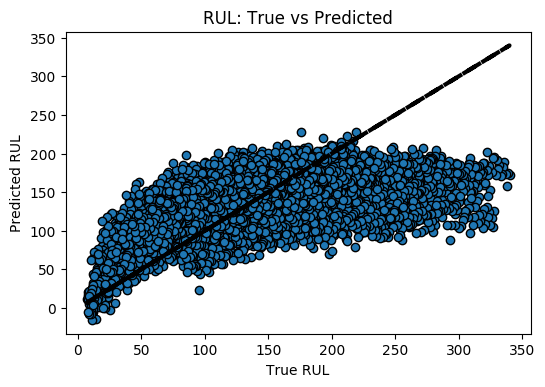

In [101]:
analyze_reg_model(train_Y,test_Y,train_X,test_X, OLS)

### Imposing a MAX RUL (85)

In [45]:
def max_rul(x):
    if (x >= 85):
        return 85
    else:
        return x
    
train_c_X = train_X
train_c_Y = train_Y.map(max_rul)

test_c_X = test_X
test_c_Y = test_Y.map(max_rul)

In [50]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
def find_best_RF_regressor(features, labels, estimators=[j for j in range(50,80,10)], depth=[i for i in range(5,15,2)]):
    
    parameters_grid = {'n_estimators': estimators, "max_depth": depth }
    estimator = model_selection.GridSearchCV(RandomForestRegressor(random_state=99), parameters_grid)
    estimator.fit(features, labels)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('\nBest # of Estimators: {}'.format(estimator.best_params_['n_estimators']))
    print('\nBest # of depth: {}'.format(estimator.best_params_['max_depth']))
    return estimator

In [51]:
estimator_RF = find_best_RF_regressor(train_c_X, train_c_Y)

Best estimator: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=70, n_jobs=None, oob_score=False,
                      random_state=99, verbose=0, warm_start=False)

Best # of Estimators: 70

Best # of depth: 7


Coefficient of determination Training (R2): 0.86
RMSE Training: 9.87

Coefficient of determination Testing (R2): 0.65
RMSE Testing: 8.36

Visualizing the Fit


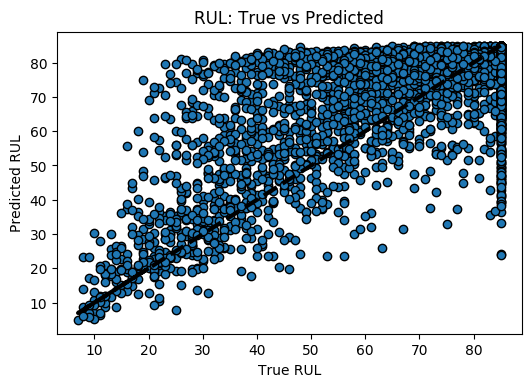

In [52]:
analyze_reg_model(train_c_Y,test_c_Y,train_c_X,test_c_X, estimator_RF)

In [55]:
from sklearn.ensemble import AdaBoostRegressor
def find_best_ADB_regressor(features, labels, estimators=[j for j in range(10,100,5)]):
    
    parameters_grid = {'n_estimators': estimators }
    estimator = model_selection.GridSearchCV(AdaBoostRegressor(random_state=99), parameters_grid)
    estimator.fit(features, labels)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('\nBest # of Estimators: {}'.format(estimator.best_params_['n_estimators']))
    return estimator

In [56]:
best_adb_reg = find_best_ADB_regressor(train_c_X, train_c_Y)

Best estimator: AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=10, random_state=99)

Best # of Estimators: 10


In [59]:
from sklearn.neighbors import KNeighborsRegressor
def find_best_params_KNR(features, labels, k_values=[2,4,8,16,32,64,128,256,512]):
    
    parameters_grid = {'n_neighbors': k_values }

    estimator = model_selection.GridSearchCV(KNeighborsRegressor(), parameters_grid)
    estimator.fit(features, labels)
    print('Best estimator: {}'.format(estimator.best_estimator_))

    print('\nBest k: {}'.format(estimator.best_params_['n_neighbors']))
    
    return estimator

In [60]:
KNN_estimator = find_best_params_KNR(train_c_X, train_c_Y)

Best estimator: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=128, p=2,
                    weights='uniform')

Best k: 128


Coefficient of determination Training (R2): 0.85
RMSE Training: 10.14

Coefficient of determination Testing (R2): 0.65
RMSE Testing: 8.27

Visualizing the Fit


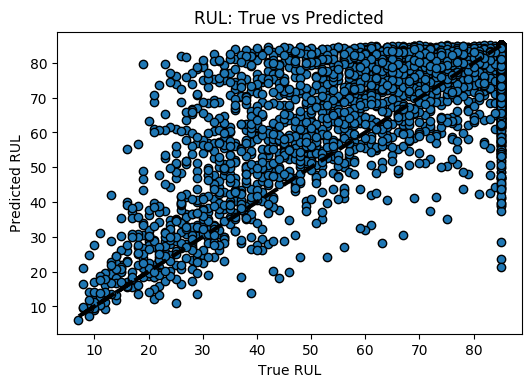

In [61]:
analyze_reg_model(train_c_Y,test_c_Y,train_c_X,test_c_X, KNN_estimator)

In [62]:
import keras
from keras.models import Sequential

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [63]:
from keras.layers import Dense, Dropout, Activation, Flatten

In [65]:
def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=5, kernel_initializer='normal', activation='relu'))
	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [67]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [71]:
estimator = KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=1)

In [72]:
estimator.fit(train_c_X, train_c_Y)

Epoch 1/50
20631/20631 [==============================] - 6s 302us/step - loss: 679.5446
Epoch 2/50
20631/20631 [==============================] - 6s 315us/step - loss: 119.8695
Epoch 3/50
20631/20631 [==============================] - 6s 303us/step - loss: 119.0345
Epoch 4/50
20631/20631 [==============================] - 6s 309us/step - loss: 118.7234
Epoch 5/50
20631/20631 [==============================] - 7s 325us/step - loss: 118.6875
Epoch 6/50
20631/20631 [==============================] - 9s 422us/step - loss: 118.5417 0s - loss
Epoch 7/50
20631/20631 [==============================] - 10s 472us/step - loss: 118.4802
Epoch 8/50
20631/20631 [==============================] - 7s 359us/step - loss: 118.4738
Epoch 9/50
20631/20631 [==============================] - 6s 305us/step - loss: 118.3999
Epoch 10/50
20631/20631 [==============================] - 7s 363us/step - loss: 118.3766
Epoch 11/50
20631/20631 [==============================] - 7s 333us/step - loss: 118.0477
Epoch 12

20631/20631 [==============================] - 1s 71us/step
Coefficient of determination Training (R2): 0.85
20631/20631 [==============================] - 1s 60us/step
RMSE Training: 10.22

13096/13096 [==============================] - 1s 65us/step
Coefficient of determination Testing (R2): 0.66
13096/13096 [==============================] - 1s 62us/step
RMSE Testing: 8.15

Visualizing the Fit
13096/13096 [==============================] - 1s 73us/step


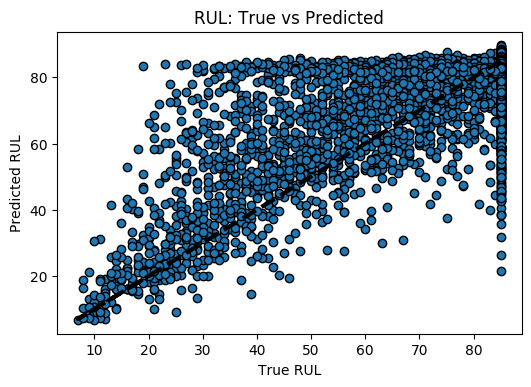

In [73]:
analyze_reg_model(train_c_Y,test_c_Y,train_c_X,test_c_X, estimator)

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

,Sensor_11,Sensor_9,Sensor_4,Sensor_12,Sensor_14
0,-0.266467,-0.862813,-0.925936,0.334262,-0.269071
1,-0.191583,-0.958818,-0.643726,1.174899,-0.642845
2,-1.015303,-0.557139,-0.525953,1.364721,-0.551629
3,-1.539489,-0.713826,-0.784831,1.961302,-0.520176
4,-0.977861,-0.457059,-0.301518,1.052871,-0.521748
...,...,...,...,...,...
20626,1.980044,0.012547,2.188375,-2.607969,-0.322542
20627,1.867718,-0.006020,2.738351,-2.350355,-0.380207
20628,2.054927,0.029755,2.138377,-1.902919,-0.141684
20629,3.178182,0.383884,1.955051,-2.363913,-0.233948


In [78]:
X_unscaled= train_new.loc[:,['Sensor_11', 'Sensor_9', 'Sensor_4', 'Sensor_12', 'Sensor_14']]

In [79]:
model = RandomForestRegressor(n_estimators=70, max_depth=7, random_state=99)
ct = ColumnTransformer([
        ('TransformFeatures', StandardScaler(), ['Sensor_11', 'Sensor_9', 'Sensor_4', 'Sensor_12', 'Sensor_14'])
    ], remainder='passthrough')
pipeline = Pipeline(steps=[('t', ct), ('m',model)])

In [80]:
pipeline.fit(X_unscaled, train_c_Y)

Pipeline(memory=None,
         steps=[('t',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('TransformFeatures',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['Sensor_11', 'Sensor_9',
                                                   'Sensor_4', 'Sensor_12',
                                                   'Sensor_14'])],
                                   verbose=False)),
                ('m',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=7,
                        

In [22]:
test_unscaled = test_new.loc[:,['Sensor_11', 'Sensor_9', 'Sensor_4', 'Sensor_12', 'Sensor_14']]

Coefficient of determination Training (R2): 0.86
RMSE Training: 9.87

Coefficient of determination Testing (R2): 0.65
RMSE Testing: 8.36

Visualizing the Fit


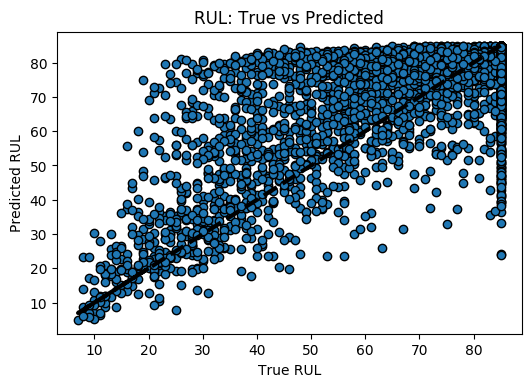

In [83]:
analyze_reg_model(train_c_Y,test_c_Y,X_unscaled,test_unscaled, pipeline)

In [84]:
import pickle
with open('regression_model_max85.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [19]:
train

,Unit_Number,Cycle#,Operational_Setting_1,Operational_Setting_2,Operational_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [23]:
test_unscaled

,Sensor_11,Sensor_9,Sensor_4,Sensor_12,Sensor_14
0,47.20,9050.17,1398.21,521.72,8125.55
1,47.50,9054.42,1395.42,522.16,8139.62
2,47.50,9056.96,1401.34,521.97,8130.10
3,47.28,9045.29,1406.42,521.38,8132.90
4,47.31,9044.55,1401.92,522.15,8129.54
...,...,...,...,...,...
13091,47.69,9142.37,1415.79,520.69,8213.28
13092,47.60,9140.68,1422.05,521.05,8210.85
13093,47.57,9146.81,1406.82,521.18,8217.24
13094,47.61,9148.85,1419.36,521.33,8220.48
